# Problem Description

## Kinematics

$ \dot{\eta} = f_\Omega(\eta) := -\Omega^\times \eta$

## Magnetometer Measurement Equation

$ y = h(\eta) = c_m \eta \in \mathbb{R}^3 $

# Equivariant Filter Design Preliminaries

## Step 1: Find a Lie Group $G$ and a state action $\phi : G \times \mathcal{M} \mapsto \mathcal{M}$

$\phi(R, \eta) := R^T \eta$

We show the state symmetry, by showing it is a right group action. Application of this action to a product of group elements is equivalent to sequential application to each element in the group.

$\phi(Y, \phi(X, \eta)) = Y^T X^T \eta = \phi(XY, \eta)$

## Step 2: Check that the System is Equivariant and Compute the Input Symmetry : $\psi : G \times \mathbb{L} \mapsto \mathbb{L}$

Define the input right group action as: 

$SO(3) \times \mathbb{R}^3 \mapsto \mathbb{R}^3$

$\psi(R, \Omega) := R^T \Omega$



The right group action used to describe the state symmetry, also induces a right group action on vector fields.

$\Phi(X, f) := D \phi_X \cdot f \circ \phi_X^{-1}$

We will use from above that:

$\phi_R(\eta) = R^T\eta$

$\phi_R^{-1}(\eta) = R\eta$

$f_\Omega(\eta) := -\Omega^\times \eta$

Substituting these functions in:

$\Phi(R, f_\Omega) = D \phi_R \cdot f_\Omega \circ \phi_R^{-1}$

$D \phi_R [v] = D_{\eta'} |_{v}  R^T\eta = \lim\limits_{t \rightarrow 0} \dfrac{R^T(\eta' + t v) - R^T(\eta')}{t} = R^T v$

$f_\Omega \circ \phi_R^{-1} = -\Omega^\times R \eta$

$\Phi(R, f_\Omega) (\eta) = - R^T \Omega^\times R \eta = - (R^T \Omega)^\times \eta = f_{\psi(R, \Omega)} (\eta)$

## Step 3: Construct an Equivariant Lift $\Lambda : \mathcal{M} \times \mathbb{L} \mapsto \mathfrak{g}$

$D_{X|id} \phi_\xi(X) [\Lambda(\xi, u)] = f_u(\xi)$

$D_{R|id} \phi_\eta(R)[v] = \lim\limits_{t \rightarrow 0} \dfrac{1}{2}$

In [65]:
import casadi as ca
import cyecca.lie as lie
from cyecca.util import rk4
from cyecca.symbolic import casadi_to_sympy
import numpy as np
import matplotlib.pyplot as plt
from ekf import derive_ekf_correct, derive_ekf_predict

In [67]:
def define_problem():
    u = ca.SX.sym("u", 3)
    x = ca.SX.sym("x", 3)
    p = ca.SX.sym("p", 0)

    x_h = ca.SX.sym("x_h", 3)
    x_e = ca.SX.sym("x_e", 3)
    t = ca.SX.sym("t")
    dt = ca.SX.sym("dt")
    cm = 1

    f_f = ca.Function(
        "f",
        [x, u, p, dt],
        [lie.SO3Dcm.exp(lie.so3.elem(-u * dt)).to_Matrix() @ x],
        ["x", "u", "p", "dt"],
        ["x1"],
    )

    f_h = ca.Function("h", [x, u, p], [x / ca.norm_2(x)], ["x", "u", "p"], ["h"])

    f_g = ca.Function("g", [x, u, p], [ca.dot(x, x)], ["x", "u", "p"], ["g"])

    f_ekf_predict = derive_ekf_predict(funcs["f_f"])
    f_ekf_correct_h = derive_ekf_correct(funcs["f_h"])
    f_ekf_correct_g = derive_ekf_correct(funcs["f_g"])
    return locals()

prob = define_problem()
f_ekf_predict = derive_ekf_predict(prob["f_f"])
f_ekf_correct_h = derive_ekf_correct(prob["f_h"])
f_ekf_correct_g = derive_ekf_correct(prob["f_g"])

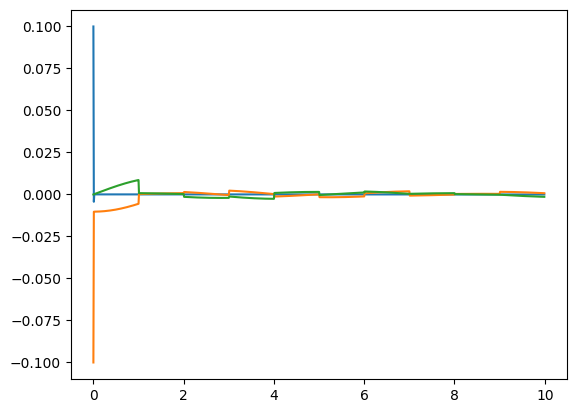

In [68]:
def simulate():
    x = np.array([1, 0, 0])
    x_h = np.array([0.9, 0.1, 0])
    
    n_x = 3
    dt = 0.01
    tf = 10
    t_vect = np.arange(0, tf, dt)
    n_t = len(t_vect)
    
    hist = {
        "x": np.zeros((n_t, n_x)),
        "x_h": np.zeros((n_t, n_x)),
        "t": t_vect,
        "P": np.zeros((n_t, n_x**2)),
    }

    u = np.array([1, 0, 0])
    p = np.array([])
    
    w_nasd = 1 # process noise amplitude spectral density
    gyro_nasd = 1 # gyro noise amplitude spectral density
    mag_std = 1e-3 # mag noise std dev.
    g_std = 1e-3 # g constraint std
    
    x0_std = 1 

    P = np.eye(3)*x0_std**2
    Q = np.eye(3)*w_nasd/np.sqrt(dt)
    M = np.eye(3)*gyro_nasd/np.sqrt(dt)
    R_h = np.eye(3)*mag_std**2
    R_g = np.eye(1)*g_std**2

    for i, t in enumerate(t_vect):
        # store
        hist["x"][i, :] = np.array(x).reshape(-1)
        hist["x_h"][i, :]  = np.array(x_h).reshape(-1)
        hist["P"][i, :] = np.array(P).reshape(-1)

        # simulate
        x = funcs["f_f"](x, u, p, dt)
        x_h, P = f_ekf_predict(x_h, u, p, P, Q, M, dt)

        # correct mag
        if i % 100 == 0:
            # magnetometer measurement
            y_h = funcs["f_h"](x, u, p) + mag_std * np.random.randn(3)
            x_h, P = f_ekf_correct_h(x_h, u, p, y_h, P, R_h)

        # correct g
        g = funcs["f_g"](x_h, u, p)
        x_h, P = f_ekf_correct_g(x_h, u, p, 1, P, R_g)

    return hist


hist = simulate()
plt.plot(hist["t"], hist["x"] - hist["x_h"]);

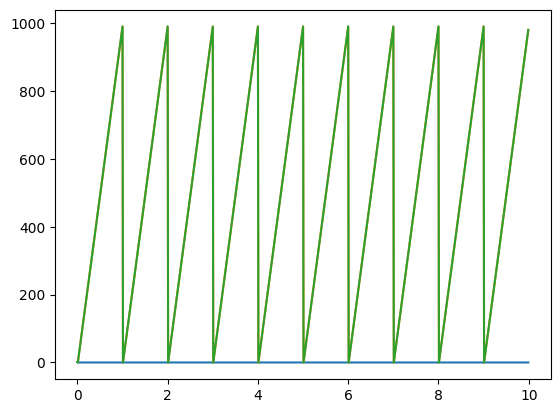

In [69]:
plt.plot(hist["t"], hist["P"][:, 0])
plt.plot(hist["t"], hist["P"][:, 4])
plt.plot(hist["t"], hist["P"][:, 8])